In [42]:
import os
import random
import datetime
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import imageio
from tqdm.notebook import tqdm

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.tensorboard import SummaryWriter

#!git clone https://github.com/ActiveVisionLab/nerfmm.git

from nerfmm.utils.pos_enc import encode_position
from nerfmm.utils.volume_op import volume_rendering, volume_sampling_ndc
from nerfmm.utils.comp_ray_dir import comp_ray_dir_cam_fxfy
from nerfmm.utils.training_utils import mse2psnr
from nerfmm.utils.lie_group_helper import convert3x4_4x4

# Settings
data_dir = os.path.join('/../kaggle/input/llff-dataset-full/nerf_llff_data/flower/images_4')
scene_title = "flower"



In [13]:
scene_title = "flower"

/tmp/ipykernel_28/4209585118.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)[:, :, :3]


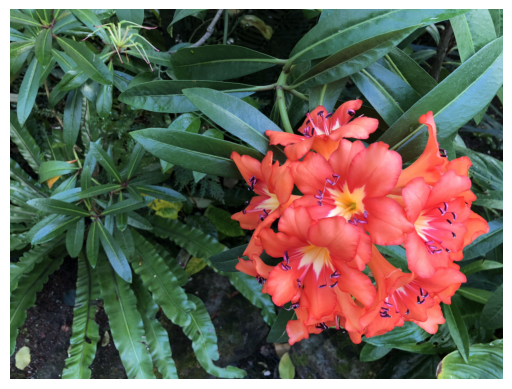

In [40]:
class ImageLoader:
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.images_info = self.retrieve_images()

    def retrieve_images(self):
        list_img_names = np.array(sorted(os.listdir(self.img_dir)))
        list_img_paths = [os.path.join(self.img_dir, img_name) for img_name in list_img_names]
        count_imgs = len(list_img_paths)

        collection_imgs = []
        for img_path in list_img_paths:
            img = imageio.imread(img_path)[:, :, :3]
            collection_imgs.append(img)

        collection_imgs = np.stack(collection_imgs)
        collection_imgs = torch.from_numpy(collection_imgs).float() / 255
        img_height, img_width = collection_imgs.shape[1], collection_imgs.shape[2]

        return {
            'imgs': collection_imgs,
            'img_names': list_img_names,
            'N_imgs': count_imgs,
            'H': img_height,
            'W': img_width,
        }
    
    def show_example(self, idx=0):
        img = self.images_info['imgs'][idx]
        plt.imshow(img)
        plt.axis('off')
        plt.show()
loader = ImageLoader(img_dir=data_dir)
loader.show_example(idx=0)  # Shows the first image

imgs = loader.images_info['imgs']  # (N, H, W, 3) torch.float32

N_IMGS = loader.images_info['N_imgs']
H = loader.images_info['H']
W = loader.images_info['W']

In [26]:
class ModelLearnFocal(nn.Module):
    def __init__(self, img_height, img_width, require_grad):
        super(ModelLearnFocal, self).__init__()
        self.img_height = img_height
        self.img_width = img_width
        self.fx = nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=require_grad)
        self.fy = nn.Parameter(torch.tensor(1.0, dtype=torch.float32), requires_grad=require_grad)

    def forward(self):
        fxfy = torch.stack([self.fx**2 * self.img_width, self.fy**2 * self.img_height])
        return fxfy

In [27]:
class LearnPose(nn.Module):
    def __init__(self, num_cams, learn_R, learn_t):
        super(LearnPose, self).__init__()
        self.num_cams = num_cams
        self.r = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_R)  # (N, 3)
        self.t = nn.Parameter(torch.zeros(size=(num_cams, 3), dtype=torch.float32), requires_grad=learn_t)  # (N, 3)

    def forward(self, camera_id):
        r = self.r[camera_id]
        t = self.t[camera_id]
        zero = torch.zeros(1, dtype=torch.float32, device=r.device)
        skew_r = torch.stack([torch.cat([ zero,    -r[2:3],   r[1:2]]),
                              torch.cat([ r[2:3],   zero,    -r[0:1]]),
                              torch.cat([-r[1:2],   r[0:1],   zero])], dim=0)  # (3, 3)
        norm_r = r.norm() + 1e-15
        eye = torch.eye(3, dtype=torch.float32, device=r.device)
        R = eye + (torch.sin(norm_r) / norm_r) * skew_r + ((1 - torch.cos(norm_r)) / norm_r**2) * (skew_r @ skew_r)
        c2w = torch.cat([R, t.unsqueeze(1)], dim=1)  # (3, 4)
        c2w = convert3x4_4x4(c2w)  # (4, 4)
        return c2w

In [28]:
class TinyNerf(nn.Module):
    def __init__(self, pos_in_dims, dir_in_dims, D):
        """
        :param pos_in_dims: scalar, number of channels of encoded positions
        :param dir_in_dims: scalar, number of channels of encoded directions
        :param D:           scalar, number of hidden dimensions
        """
        super(TinyNerf, self).__init__()

        self.pos_in_dims = pos_in_dims
        self.dir_in_dims = dir_in_dims

        self.layers0 = nn.Sequential(
            nn.Linear(pos_in_dims, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
            nn.Linear(D, D), nn.ReLU(),
        )

        self.fc_density = nn.Linear(D, 1)
        self.fc_feature = nn.Linear(D, D)
        self.rgb_layers = nn.Sequential(nn.Linear(D + dir_in_dims, D//2), nn.ReLU())
        self.fc_rgb = nn.Linear(D//2, 3)

        self.fc_density.bias.data = torch.tensor([0.1]).float()
        self.fc_rgb.bias.data = torch.tensor([0.02, 0.02, 0.02]).float()

    def forward(self, pos_enc, dir_enc):
        """
        :param pos_enc: (H, W, N_sample, pos_in_dims) encoded positions
        :param dir_enc: (H, W, N_sample, dir_in_dims) encoded directions
        :return: rgb_density (H, W, N_sample, 4)
        """
        x = self.layers0(pos_enc)  # (H, W, N_sample, D)
        density = self.fc_density(x)  # (H, W, N_sample, 1)

        feat = self.fc_feature(x)  # (H, W, N_sample, D)
        x = torch.cat([feat, dir_enc], dim=3)  # (H, W, N_sample, D+dir_in_dims)
        x = self.rgb_layers(x)  # (H, W, N_sample, D/2)
        rgb = self.fc_rgb(x)  # (H, W, N_sample, 3)

        rgb_den = torch.cat([rgb, density], dim=3)  # (H, W, N_sample, 4)
        return rgb_den

In [29]:
class RayParameters():
    def __init__(self):
      self.NEAR, self.FAR = 2.0, 6.0  # ndc near far
      self.N_SAMPLE = 64  # samples per ray
      self.POS_ENC_FREQ = 10  # positional encoding freq for location
      self.DIR_ENC_FREQ = 4   # positional encoding freq for direction

ray_params = RayParameters()

In [44]:
class ImageRenderer:
    def __init__(self, rayParameters, focalPoints, nerfModel):
        self.rayParameters = rayParameters
        self.focalPoints = focalPoints
        self.nerfModel = nerfModel

    def render(self, camToWorld, camRays, depthSamples, height, width, perturbDepth, noiseStd):
        """
        :param camToWorld: (4, 4)                  pose to transform ray direction from cam to world.
        :param camRays:    (someH, someW, 3)       ray directions in camera coordinate, can be random selected
                                                    rows and cols, or some full rows, or an entire image.
        :param depthSamples: (N_samples)             sample depth along a ray.
        :param perturbDepth:   True/False          perturb t values.
        :param noiseStd: float                     add noise to raw density predictions (sigma).
        :return:           (someH, someW, 3)       volume rendered images for the input rays.
        """
        sampledPositions, _, worldRayDirections, noisyDepthSamples = volume_sampling_ndc(camToWorld, camRays, depthSamples, 
            self.rayParameters.NEAR, self.rayParameters.FAR, height, width, self.focalPoints, perturbDepth)
            
        encodedPositions = encode_position(sampledPositions, levels=self.rayParameters.POS_ENC_FREQ, inc_input=True)
        worldRayDirections = F.normalize(worldRayDirections, p=2, dim=2)
        
        encodedDirections = encode_position(worldRayDirections, levels=self.rayParameters.DIR_ENC_FREQ, inc_input=True)  
        encodedDirections = encodedDirections.unsqueeze(2).expand(-1, -1, self.rayParameters.N_SAMPLE, -1)  

        rgbDensity = self.nerfModel(encodedPositions, encodedDirections)  
        
        renderingResult = volume_rendering(rgbDensity, noisyDepthSamples, noiseStd, rgb_act_fn=torch.sigmoid)
        
        renderedRgb = renderingResult['rgb']  
        depthMap = renderingResult['depth_map']  

        result = {
            'rgb': renderedRgb,  
            'depth_map': depthMap,  
        }

        return result


def train_one_epoch(imageData, imgHeight, imgWidth, rayParameters, optimizerNerf, optimizerFocal,
                    optimizerPose, nerfModel, focalNetwork, poseParamNetwork, sample_om_image_size = 32):
    
    nerfModel.train()
    focalNetwork.train()
    poseParamNetwork.train()

    depthSamples = torch.linspace(rayParameters.NEAR, rayParameters.FAR, rayParameters.N_SAMPLE, device='cuda')  
    L2LossEpoch = []

    # shuffle the training images
    imageIDs = np.arange(N_IMGS)
    np.random.shuffle(imageIDs)

    for imageID in imageIDs:
        focalPoints = focalNetwork()

        cameraRayDir = comp_ray_dir_cam_fxfy(imgHeight, imgWidth, focalPoints[0], focalPoints[1])
        image = imageData[imageID].to('cuda')  
        camToWorld = poseParamNetwork(imageID)  

        rowIndex = torch.randperm(imgHeight, device='cuda')[:sample_om_image_size]  
        columnIndex = torch.randperm(imgWidth, device='cuda')[:sample_om_image_size]  
        selectedCameraRays = cameraRayDir[rowIndex][:, columnIndex]  
        selectedImage = image[rowIndex][:, columnIndex]  

        # Render an image using selected rays, pose, sample intervals, and the network
        imageRenderer = ImageRenderer(rayParameters, focalPoints, nerfModel)
        renderingResult = imageRenderer.render(camToWorld, selectedCameraRays, depthSamples, imgHeight, imgWidth, True, 0.0)

        renderedRgb = renderingResult['rgb']  
        L2Loss = F.mse_loss(renderedRgb, selectedImage)  

        L2Loss.backward()
        optimizerNerf.step()
        optimizerFocal.step()
        optimizerPose.step()
        optimizerNerf.zero_grad()
        optimizerFocal.zero_grad()
        optimizerPose.zero_grad()

        L2LossEpoch.append(L2Loss)

    meanL2LossEpoch = torch.stack(L2LossEpoch).mean().item()
    return meanL2LossEpoch


In [45]:
def render_novel_view(c2w, H, W, fxfy, ray_params, nerf_model):
    nerf_model.eval()

    ray_dir_cam = comp_ray_dir_cam_fxfy(H, W, fxfy[0], fxfy[1])
    t_vals = torch.linspace(ray_params.NEAR, ray_params.FAR, ray_params.N_SAMPLE, device='cuda')  # (N_sample,) sample position

    c2w = c2w.to('cuda')  # (4, 4)

    # split an image to rows when the input image resolution is high
    rays_dir_cam_split_rows = ray_dir_cam.split(10, dim=0)  # input 10 rows each time
    rendered_img = []
    rendered_depth = []
    for rays_dir_rows in rays_dir_cam_split_rows:
        
        renderer = ImageRenderer(ray_params, fxfy, nerf_model)
        render_result = renderer.render(c2w, rays_dir_rows, t_vals, H, W, False, 0.0)

        rgb_rendered_rows = render_result['rgb']  # (num_rows_eval_img, W, 3)
        depth_map = render_result['depth_map']  # (num_rows_eval_img, W)

        rendered_img.append(rgb_rendered_rows)
        rendered_depth.append(depth_map)

    # combine rows to an image
    rendered_img = torch.cat(rendered_img, dim=0)  # (H, W, 3)
    rendered_depth = torch.cat(rendered_depth, dim=0)  # (H, W)
    return rendered_img, rendered_depth

In [46]:
N_EPOCH = 500
EVAL_INTERVAL = 50


focal_net = ModelLearnFocal(H, W, require_grad=True).cuda()
pose_param_net = LearnPose(num_cams=N_IMGS, learn_R=True, learn_t=True).cuda()

nerf_model = TinyNerf(pos_in_dims=63, dir_in_dims=27, D=128).cuda()

opt_nerf = torch.optim.Adam(nerf_model.parameters(), lr=0.001)
opt_focal = torch.optim.Adam(focal_net.parameters(), lr=0.001)
opt_pose = torch.optim.Adam(pose_param_net.parameters(), lr=0.001)

from torch.optim.lr_scheduler import MultiStepLR
scheduler_nerf = MultiStepLR(opt_nerf, milestones=list(range(0, 10000, 10)), gamma=0.9954)
scheduler_focal = MultiStepLR(opt_focal, milestones=list(range(0, 10000, 100)), gamma=0.9)
scheduler_pose = MultiStepLR(opt_pose, milestones=list(range(0, 10000, 100)), gamma=0.9)

# Set tensorboard writer
writer = SummaryWriter(log_dir=os.path.join('logs', scene_title, str(datetime.datetime.now().strftime('%y%m%d_%H%M%S'))))

# Store poses to visualise them later
pose_history = []

# Training
print('Training... Check results in the tensorboard above.')
for epoch_i in tqdm(range(N_EPOCH), desc='Training'):
    L2_loss = train_one_epoch(imgs, H, W, ray_params, opt_nerf, opt_focal,
                              opt_pose, nerf_model, focal_net, pose_param_net, 32)
    train_psnr = mse2psnr(L2_loss)

    writer.add_scalar('train/psnr', train_psnr, epoch_i)

    fxfy = focal_net()
    print('epoch {0:4d} Training PSNR {1:.3f}, estimated fx {2:.1f} fy {3:.1f}'.format(epoch_i, train_psnr, fxfy[0], fxfy[1]))

    scheduler_nerf.step()
    scheduler_focal.step()
    scheduler_pose.step()

    learned_c2ws = torch.stack([pose_param_net(i) for i in range(N_IMGS)])  # (N, 4, 4)
    pose_history.append(learned_c2ws[:, :3, 3])  # (N, 3) only store positions as we vis in 2D.

    with torch.no_grad():
        if (epoch_i+1) % EVAL_INTERVAL == 0:
            eval_c2w = torch.eye(4, dtype=torch.float32)  # (4, 4)
            fxfy = focal_net()
            rendered_img, rendered_depth = render_novel_view(eval_c2w, H, W, fxfy, ray_params, nerf_model)
            writer.add_image('eval/img', rendered_img.permute(2, 0, 1), global_step=epoch_i)
            writer.add_image('eval/depth', rendered_depth.unsqueeze(0), global_step=epoch_i)

pose_history = torch.stack(pose_history).detach().cpu().numpy()  # (N_epoch, N_img, 3)
print('Training finished.')

Training... Check results in the tensorboard above.


Training:   0%|          | 0/500 [00:00<?, ?it/s]

epoch    0 Training PSNR 12.012, estimated fx 1009.9 fy 752.6
epoch    1 Training PSNR 12.607, estimated fx 989.9 fy 749.0
epoch    2 Training PSNR 12.700, estimated fx 979.6 fy 746.5
epoch    3 Training PSNR 12.839, estimated fx 988.9 fy 732.4
epoch    4 Training PSNR 13.230, estimated fx 1000.1 fy 750.8
epoch    5 Training PSNR 13.424, estimated fx 1065.7 fy 800.8
epoch    6 Training PSNR 13.721, estimated fx 1060.2 fy 809.4
epoch    7 Training PSNR 13.934, estimated fx 1068.3 fy 814.5
epoch    8 Training PSNR 14.097, estimated fx 1091.3 fy 794.7
epoch    9 Training PSNR 14.331, estimated fx 1124.1 fy 792.7
epoch   10 Training PSNR 14.661, estimated fx 1130.2 fy 792.7
epoch   11 Training PSNR 14.578, estimated fx 1138.4 fy 792.6
epoch   12 Training PSNR 14.863, estimated fx 1146.9 fy 778.0
epoch   13 Training PSNR 15.006, estimated fx 1140.2 fy 771.4
epoch   14 Training PSNR 15.210, estimated fx 1148.7 fy 768.8
epoch   15 Training PSNR 15.180, estimated fx 1152.4 fy 768.0
epoch   16 

In [49]:
from nerfmm.utils.pose_utils import create_spiral_poses

# Render full images are time consuming, especially on colab so we render a smaller version instead.
resize_ratio = 4
with torch.no_grad():
    optimised_poses = torch.stack([pose_param_net(i) for i in range(N_IMGS)])
    radii = np.percentile(np.abs(optimised_poses.cpu().numpy()[:, :3, 3]), q=50, axis=0)  # (3,)
    spiral_c2ws = create_spiral_poses(radii, focus_depth=3.5, n_poses=30, n_circle=1)
    spiral_c2ws = torch.from_numpy(spiral_c2ws).float()  # (N, 3, 4)

    # change intrinsics according to resize ratio
    fxfy = focal_net()
    novel_fxfy = fxfy / resize_ratio
    novel_H, novel_W = H // resize_ratio, W // resize_ratio

    novel_img_list, novel_depth_list = [], []
    for i in tqdm(range(spiral_c2ws.shape[0]), desc='novel view rendering'):
        novel_img, novel_depth = render_novel_view(spiral_c2ws[i], novel_H, novel_W, novel_fxfy,
                                                   ray_params, nerf_model)
        novel_img_list.append(novel_img)
        novel_depth_list.append(novel_depth)

    novel_img_list = (torch.stack(novel_img_list) * 255).cpu().numpy().astype(np.uint8)
    novel_depth_list = (torch.stack(novel_depth_list) * 200).cpu().numpy().astype(np.uint8)  # depth is always in 0 to 1 in NDC

    os.makedirs('nvs_results_for_real', exist_ok=True)
    imageio.mimwrite(os.path.join('nvs_results_for_real', scene_title + '2_img.gif'), novel_img_list, duration=1000 * 1/30)
    imageio.mimwrite(os.path.join('nvs_results_for_real', scene_title + '2_depth.gif'), novel_depth_list, duration=1000 * 1/30)

novel view rendering:   0%|          | 0/30 [00:00<?, ?it/s]

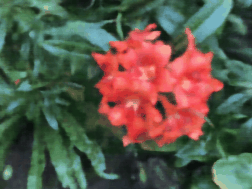

In [50]:
Image(open(os.path.join('nvs_results_for_real', scene_title + '2_img.gif'), 'rb').read())